# *COVID-19 Community Mobility Reports:​ Regression*

### Authors:
- Ana Mafalda Santos, up201706791
- Diogo Silva, up201706892
- João Luz, up201703782

## Introduction
---
The main purpose of this project was to build a regression model using different **Supervised Learning** algorithms for the given dataset: **CoV-19 Community Mobility Report**.

After analyzing and handling our dataset, we aim to predict the number of people infected by SARS-CoV-2 based on the variation of the population's mobility trends. To make it less biased, we'll predict the confirmed cases per million instead of using just the total amount of cases, as different countries have different population sizes.

## Description of the Problem/Dataset
---
Our dataset - **CoV-19 Community Mobility Report** - seeks to provide insights into what has changed due to policies aimed at combating COVID-19 and evaluate the changes in community activities and its relation to reduced confirmed cases of COVID-19. The reports chart movement trends, comparing to an expected baseline, over time by geography, across the following categories of places:

* **Retail & Recreation**: mobility trends for places like restaurants, cafes, shopping centers, theme parks, museums, libraries, and movie theaters.
* **Grocery & Pharmacy**: mobility trends for places like grocery markets, food warehouses, farmers' markets, specialty food shops, drug stores, and pharmacies.
* **Parks**: mobility trends for places like national parks, public beaches, marinas, dog parks, plazas, and public gardens.
* **Transit stations**: mobility trends for places like public transport hubs such as subway, bus, and train stations.
* **Workplaces**: mobility trends for places of work.
* **Residential**: mobility trends for places of residence.

The dataset also contains these CoV-19 statistics:

* **Total Cases**: Total number of people infected with the SARS-CoV-2.
* **Fatalities**: Total number of deaths caused by CoV-19.
* **Population**: Total number of inhabitants.

## Approach
---
We start by pre-processing the data we had. To compensate for missing and NaN values on the dataset, we used Median and Zero Imputation, to better infer those missing values from the existing part of the data. We also added new columns to extract more reliable information from the existing columns:

* **New Cases (percentage)**: variation of the total cases of CoV-19 cases in comparison to the previous day.
* **New Fatalities (percentage)**: variation of the total fatalities of CoV-19 cases in comparison to the previous day.
* **Cases per Million**: total cases CoV-19 cases per million people.

In order to improve the model, several ways of partitioning the input data into training and testing data have been considered, such as Train/Test Split and K-Fold Cross Validation.

To predict the number of people infected based on the available data, we used different algorithms for our regression model: **Support Vector Regression (SVR)**, **K-Nearest Neighbors**, **Decision Trees** and **Neural Networks (Perceptron)**.

At last, we tried to reduce the dimension of our dataset by using Principal Component Analysis (PCA) which combines highly correlated variables together to form a smaller number of an artificial set of variables that account for the most variance in the data.

## Experimental Evaluation
---
In this section we will try to provide a step-by-step explanation of our approach and show the way different factors shaped our implementation along the way. 


In [1]:
import math
import numpy as np
import pandas as pd

from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import cross_validate, train_test_split, KFold, cross_val_predict
from sklearn import preprocessing, linear_model, neighbors
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

from matplotlib import style
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates


In [2]:
# Reads CVS file to Data Frame
data = pd.read_csv('Global_Mobility_Report.csv')


After reading the input file, we proceed to select and analyze its data. Since we will predict the number of cases of CoV-19 and these might depend on country-specific factors, it may be relevant to focus on a specific region in order to effectively and impartially compare the performance of the algorithms. Being one of the most affected countries in the world, the US seemed as a good candidate for this research.

In [3]:
country = 'US'
data = data.loc[(data.country == country)]
data = data.reset_index(drop=True)
# It would intersting to take care of the Dummy Variable Trap 
# if we were taking the country column into account.
# Alternatively, we chose to eliminate these columns completely.
data = data.drop(columns = ['country','iso'])
data

,date,grocery_pharmacy,parks,residential,retail_recreation,transit_stations,workplaces,total_cases,fatalities,population
0,2/23/2020,3.124,22.982,-0.823,6.813,4.992,2.238,0,0,329064917
1,2/24/2020,0.717,9.233,0.040,1.709,1.285,2.776,0,0,329064917
2,2/25/2020,1.222,9.106,-0.138,4.031,2.155,1.899,0,0,329064917
3,2/26/2020,2.464,5.209,-0.630,7.340,3.498,2.198,0,0,329064917
4,2/27/2020,3.429,12.251,-0.459,7.503,4.013,1.834,0,0,329064917
5,2/28/2020,3.392,9.685,-1.284,7.996,5.340,2.428,0,0,329064917
6,2/29/2020,7.349,20.717,-1.858,11.518,7.367,4.403,0,0,329064917
7,3/1/2020,8.816,17.755,-1.490,12.864,6.691,2.954,0,0,329064917
8,3/2/2020,6.123,10.253,-0.571,7.283,1.694,2.979,0,0,329064917
9,3/3/2020,9.870,20.048,-0.914,10.780,2.976,2.024,0,0,329064917


#### Extraction of new relevant columns:

In [4]:
# Calculates daily percentual changes in number of fatalities
data['fatalities_percent_change'] = pd.Series([])

for i in range(0,len(data['fatalities'])):
    if i != 0 and data['fatalities'][i-1] != 0:
        data['fatalities_percent_change'][i]= (data['fatalities'][i] - data['fatalities'][i-1]) * 100 /data['fatalities'][i-1]
    else:data['fatalities_percent_change'][i] = 0

# Calculates daily percentual changes in number of cases
data['cases_percent_change'] = pd.Series([])
for i in range(0,len(data['total_cases'])):
    if i != 0 and data['total_cases'][i-1] != 0:
        data['cases_percent_change'][i]= (data['total_cases'][i] - data['total_cases'][i-1]) * 100 /data['total_cases'][i-1]
    else:data['cases_percent_change'][i] = 0

# Calculates cases of covid per million inhabitants
data['cases_per_million'] = pd.Series([])
for i in range(0,len(data['total_cases'])):
    millions = data['population'][i]/1000000
    data['cases_per_million'][i]= data['total_cases'][i]/millions

# Drop unnecessary columns from data set
data = data.drop(columns = ['fatalities'])
data = data.drop(columns = ['total_cases'])
data = data.drop(columns = ['population'])

data

,date,grocery_pharmacy,parks,residential,retail_recreation,transit_stations,workplaces,fatalities_percent_change,cases_percent_change,cases_per_million
0,2/23/2020,3.124,22.982,-0.823,6.813,4.992,2.238,0.000000,0.000000,0.000000
1,2/24/2020,0.717,9.233,0.040,1.709,1.285,2.776,0.000000,0.000000,0.000000
2,2/25/2020,1.222,9.106,-0.138,4.031,2.155,1.899,0.000000,0.000000,0.000000
3,2/26/2020,2.464,5.209,-0.630,7.340,3.498,2.198,0.000000,0.000000,0.000000
4,2/27/2020,3.429,12.251,-0.459,7.503,4.013,1.834,0.000000,0.000000,0.000000
5,2/28/2020,3.392,9.685,-1.284,7.996,5.340,2.428,0.000000,0.000000,0.000000
6,2/29/2020,7.349,20.717,-1.858,11.518,7.367,4.403,0.000000,0.000000,0.000000
7,3/1/2020,8.816,17.755,-1.490,12.864,6.691,2.954,0.000000,0.000000,0.000000
8,3/2/2020,6.123,10.253,-0.571,7.283,1.694,2.979,0.000000,0.000000,0.000000
9,3/3/2020,9.870,20.048,-0.914,10.780,2.976,2.024,0.000000,0.000000,0.000000


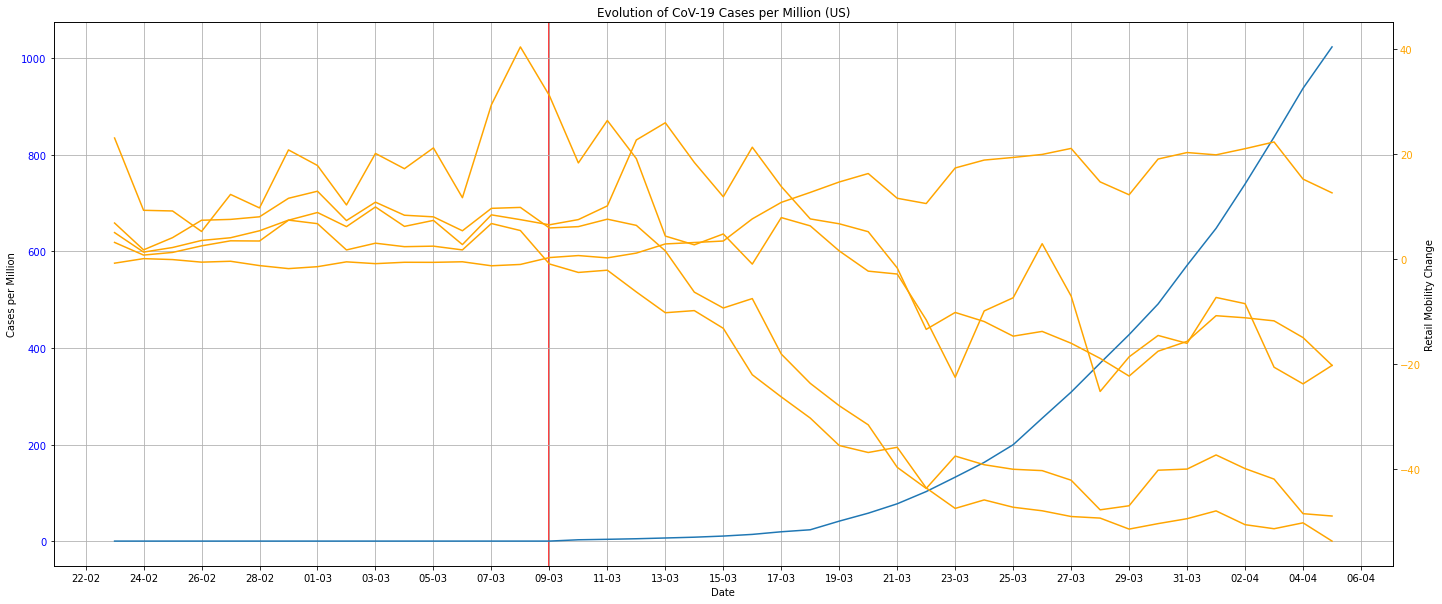

In [5]:
# We start by looking for the day of the first confirmed cases.
starting_day = pd.to_datetime(data['date'][0])
day_index = 0
for day_index in range(0,len(data['cases_per_million'])):
    if data['cases_per_million'][day_index] != 0:
        starting_day = pd.to_datetime(data['date'][day_index -1])
        break

dates = data['date']
date_format = [pd.to_datetime(d) for d in dates]

# A first look at the evolution of the number of confirmed cases per million 
# and how the mobility (namely retail and recreation) was affected.
_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
ax.plot(date_format, data['cases_per_million'])
ax.set(xlabel="Date", ylabel='Cases per Million', title=("Evolution of CoV-19 Cases per Million (%s)" % (country)))
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.axvline(starting_day, c="red", zorder=0)
ax.tick_params(axis='y', labelcolor= "blue")
ax2 = ax.twinx()  
ax2.set_ylabel('Retail Mobility Change')
ax2.plot(date_format, data['grocery_pharmacy'], color = "orange")
ax2.plot(date_format, data['parks'], color = "orange")
ax2.plot(date_format, data['residential'], color = "orange")
ax2.plot(date_format, data['retail_recreation'], color = "orange")
ax2.plot(date_format, data['transit_stations'], color = "orange")

ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax2.tick_params(axis='y', labelcolor= "orange")
plt.show()

As we can see from the graph above, when the first cases of CoV-19 were registered, the overall mobility dropped considerably, with exception of the residential trendline which, given the context of our dataset, increases as expected. For this reason we will only consider data starting from that inflexion point on.

That being said, we can now define the Total Number of Cases per Million as our **target variable** and isolate it from our **independent variables**. 

In [6]:
X = data.iloc[day_index:,1:9]
Y = data.iloc[day_index:,9:]
Y

,cases_per_million
16,2.710711
17,3.689242
18,4.850107
19,6.418186
20,8.077434
21,10.426514
22,13.872643
23,19.306221
24,23.445222
25,41.353542


In [7]:
# Replaces NaN values present in the new columns by 0 (Zero Inputation)
X['fatalities_percent_change'] = X['fatalities_percent_change'].replace(np.NaN, 0)
X['cases_percent_change'] = X['cases_percent_change'].replace(np.NaN, 0)
Y['cases_per_million'] = Y['cases_per_million'].replace(np.NaN, 0)

# Fills the empty values taking mean values present in each column (Mean Inputation)
X = X.replace("", np.NaN)
Y = Y.replace("", np.NaN)
imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')
X = imputer.fit_transform(X)
Y = imputer.fit_transform(Y)

Y

array([[   2.71071133],
       [   3.68924166],
       [   4.85010683],
       [   6.41818648],
       [   8.07743355],
       [  10.42651411],
       [  13.87264264],
       [  19.30622097],
       [  23.4452219 ],
       [  41.35354241],
       [  57.81533982],
       [  77.29477889],
       [ 102.60893294],
       [ 132.45410783],
       [ 163.06508907],
       [ 199.65969207],
       [ 254.53640201],
       [ 308.69288931],
       [ 368.65978028],
       [ 427.74842509],
       [ 491.32858487],
       [ 571.37054206],
       [ 647.93902049],
       [ 739.79627552],
       [ 836.99594144],
       [ 938.09149518],
       [1023.84661079]])

To prevent a feature that has a variance that is orders of magnitude larger than others, from dominating the objective function and make the estimator unable to learn from other features correctly as expected, it is wise to perform a standardization of such features.

In [8]:
# Standardization using Gaussian Normal Distribution
X = preprocessing.scale(X)

Once pre-processed, our data can now be divided in subsets meant for training and testing our models. Usually it would be very convinient to make use of K-Fold Cross Validation (recommended for big datasets), since it provides a better way of partitioning the data into the mentioned subsets, leading to greater results. Unfortunately, given the small dimension of our dataset, we were not able to obtain satisfactory enough results in order to use this method. Thus, we decided to apply Train/Test Split (80%/20%) which randomly selects the input and output data as training or testing data.

In [9]:
# Create training and testing vars
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

We are now ready to start training and testing our models.

### Support Vector Regression


In [10]:
# Linear Regression Model
lm = linear_model.LinearRegression()

# Suport Vector Regression Models
svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)

# Fitting/Training models
model = lm.fit(X_train, Y_train)
svr_lin_model = svr_lin.fit(X_train, Y_train)
svr_rbf_model = svr_rbf.fit(X_train, Y_train)
svr_poly_model = svr_poly.fit(X_train, Y_train)

# Obtaining predictions from models
linear_predictions = lm.predict(X)
svr_lin_predictions = svr_lin_model.predict(X)
svr_rbf_predictions = svr_rbf_model.predict(X)
svr_poly_predictions = svr_poly_model.predict(X)

# Testing models
linear_score = model.score(X_test, Y_test)
svr_lin_score = svr_lin_model.score(X_test, Y_test)
svr_rbf_score = svr_rbf_model.score(X_test, Y_test)
svr_poly_score = svr_poly_model.score(X_test, Y_test)

print("Score:", linear_score)
print("lin Regression Model Score: %s" % (svr_lin_score))
print("rbf Regression Model Score: %s" % (svr_rbf_score))
print("POLY Regression Model Score: %s" % (svr_poly_score))

Score: 0.031080687136270768
lin Regression Model Score: 0.32542608235709447
rbf Regression Model Score: 0.5654923247363033
POLY Regression Model Score: 0.8284091818748214


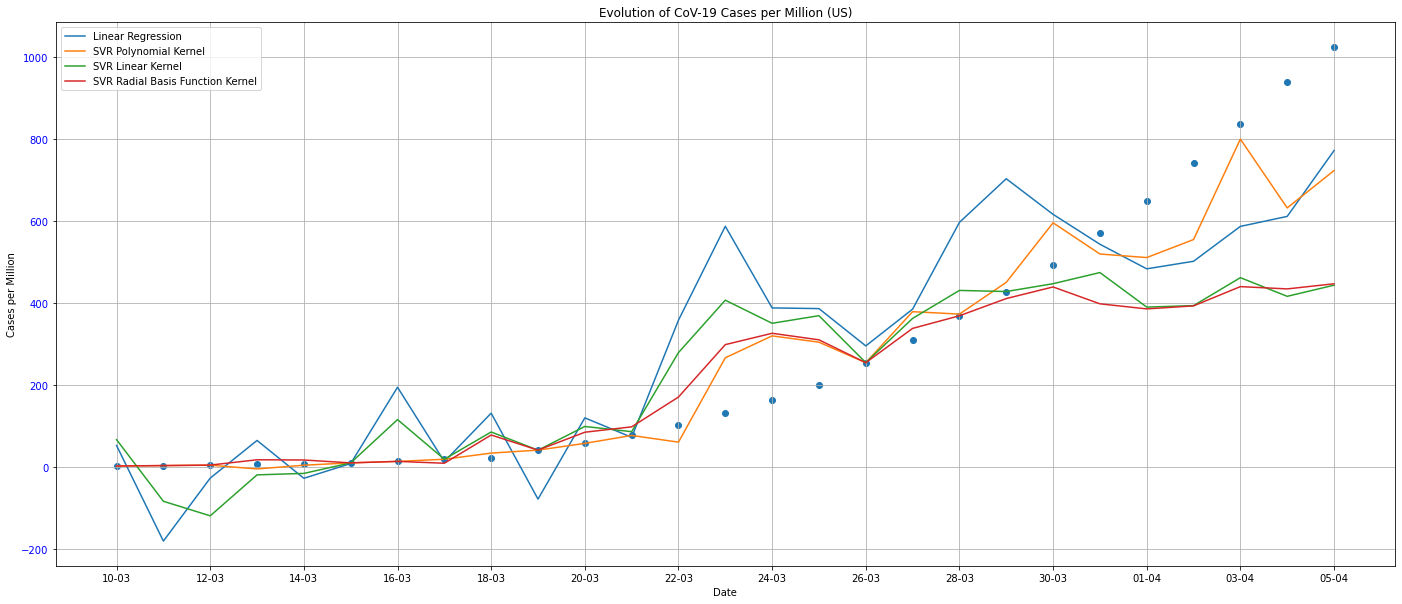

In [11]:
# Visual Comparison of the predictions obtained by different 
# parameterizations of the SVR model compared to a Linear Regression model
dates = data['date']
date_format = [pd.to_datetime(d) for d in dates]
_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
ax.scatter(date_format[day_index:], data['cases_per_million'][day_index:])
linear_plot, = ax.plot(date_format[day_index:], linear_predictions)
svr_poly_plot, = ax.plot(date_format[day_index:], svr_poly_predictions)
svr_lin_plot, = ax.plot(date_format[day_index:], svr_lin_predictions)
svr_rbf_plot, = ax.plot(date_format[day_index:], svr_rbf_predictions)
ax.legend((linear_plot, svr_poly_plot, svr_lin_plot, svr_rbf_plot), ('Linear Regression', 'SVR Polynomial Kernel','SVR Linear Kernel', 'SVR Radial Basis Function Kernel'), loc='upper left', shadow=False)

ax.set(xlabel="Date", ylabel='Cases per Million', title=("Evolution of CoV-19 Cases per Million (%s)" % (country)))
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.tick_params(axis='y', labelcolor= "blue")

In [12]:
### K-Nearest Neighbor

KNN Regression Model - Uniform:  0.6942172950268841
KNN Regression Model - Distance:  0.7533504114152284


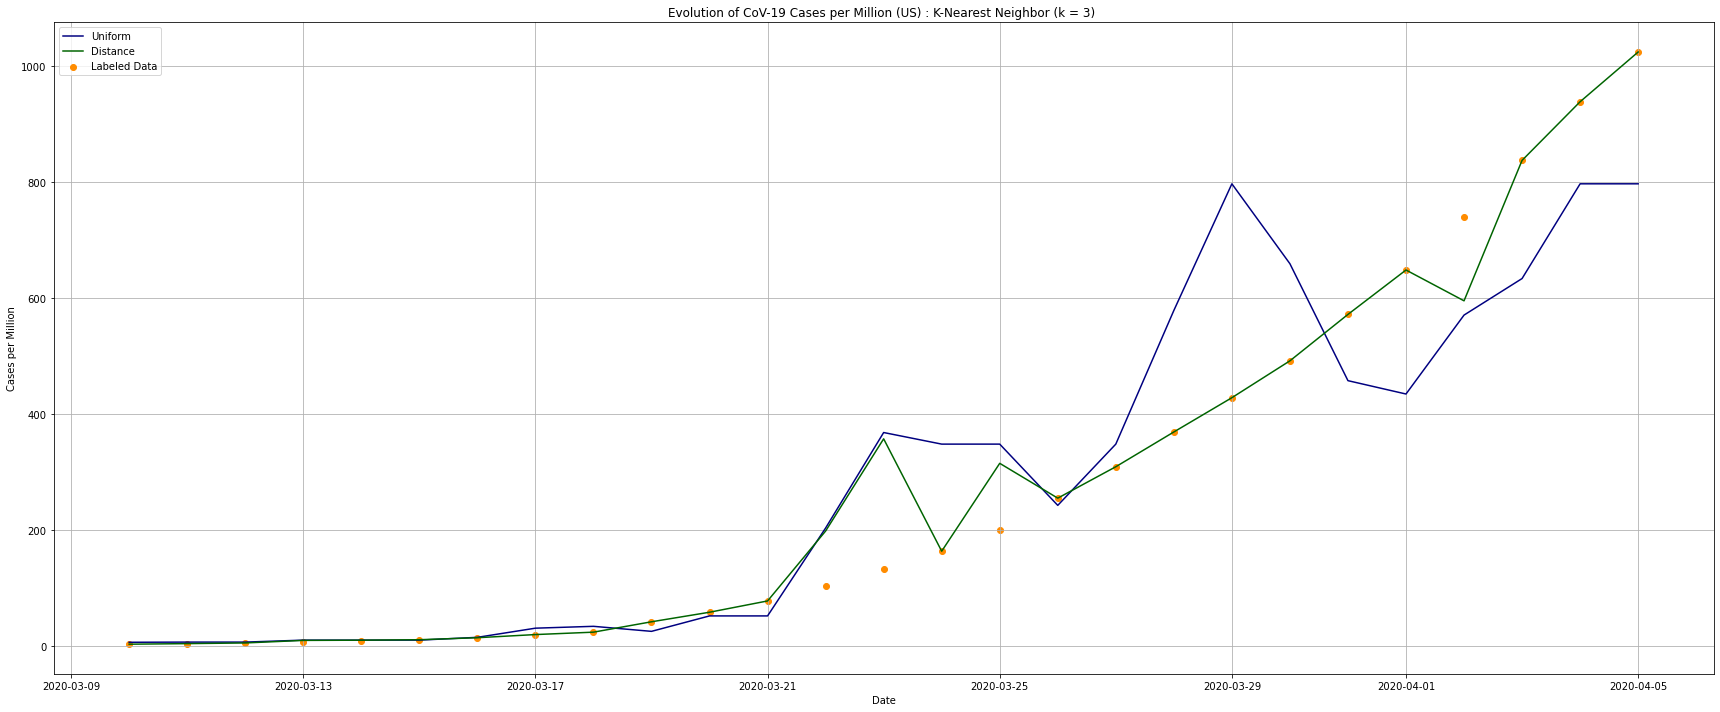

In [13]:
n_neighbors = 3
# K-Nearest Neighbor Models
knn_uniform = neighbors.KNeighborsRegressor(n_neighbors, weights='uniform')
knn_distance = neighbors.KNeighborsRegressor(n_neighbors, weights='distance')

# Fitting/Training and obtaining predictions from models
knn_predictions_uniform = knn_uniform.fit(X_train, Y_train).predict(X)
knn_predictions_distance = knn_distance.fit(X_train, Y_train).predict(X)

# Testing models
knn_uniform_score = knn_uniform.score(X_test, Y_test)
knn_distance_score = knn_distance.score(X_test, Y_test)

print("KNN Regression Model - Uniform:  %s"  % (knn_uniform_score))
print("KNN Regression Model - Distance:  %s"  % (knn_distance_score))

# Visual Comparison of the predictions obtained by different 
# parameterizations of the KNN model
_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
labeled = ax.scatter(date_format[day_index:], Y, color='darkorange', label='data')
unif, = ax.plot(date_format[day_index:], knn_predictions_uniform, color='navy')
dist, = ax.plot(date_format[day_index:], knn_predictions_distance, color='darkgreen')
ax.legend((unif, dist, labeled), ('Uniform', 'Distance','Labeled Data'), loc='upper left', shadow=False)
ax.set(xlabel="Date", ylabel='Cases per Million', title = "Evolution of CoV-19 Cases per Million (%s) : K-Nearest Neighbor (k = %i) " % (country, n_neighbors))
ax.axis('tight')
plt.tight_layout()
plt.show()

In [14]:
### Decision Tree Regression

DT2 0.7595125380943595
DT10 0.8728069100137587


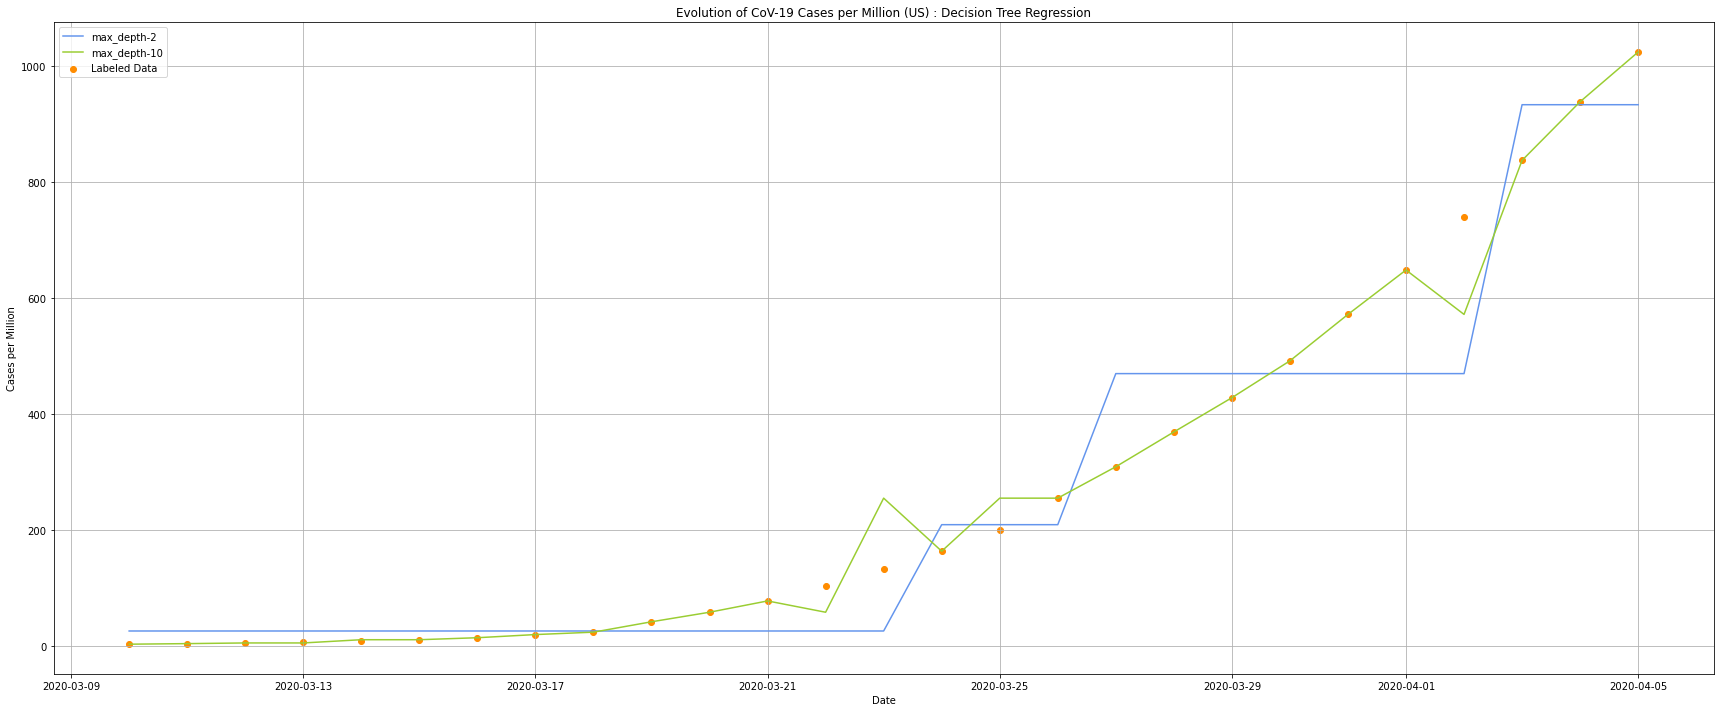

In [15]:
# Decision Tree Models
dt_regressor_2 = DecisionTreeRegressor(max_depth=2)
dt_regressor_10 = DecisionTreeRegressor(max_depth=10)

# Fitting/Training models
dt_regressor_2.fit(X_train, Y_train)
dt_regressor_10.fit(X_train, Y_train)

# Obtaining predictions from models
max_depth2_prediction = dt_regressor_2.predict(X)
max_depth10_prediction = dt_regressor_10.predict(X)

# Testing models
dt_regressor_2_score = dt_regressor_2.score(X_test,Y_test)
dt_regressor_10_score = dt_regressor_10.score(X_test,Y_test)

print("DT2", dt_regressor_2_score)
print("DT10", dt_regressor_10_score)

# Plot the results
_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
labeled = ax.scatter(date_format[day_index:], Y, color='darkorange', label='data')
max_depth2, = ax.plot(date_format[day_index:], max_depth2_prediction, color='cornflowerblue')
max_depth10, = ax.plot(date_format[day_index:], max_depth10_prediction, color='yellowgreen')
ax.legend((max_depth2, max_depth10, labeled), ('max_depth-2', 'max_depth-10','Labeled Data'), loc='upper left', shadow=False)
ax.set(xlabel="Date", ylabel='Cases per Million', title = "Evolution of CoV-19 Cases per Million (%s) : Decision Tree Regression" % (country))
plt.tight_layout()
plt.show()

Usually it would be risky to use a high value for the max_depth parameter of a decision tree, since it can lead to the model learning from noise present in the data and be prone to **overfit**. Fortunately, given that our data does not contain noise and was handled carefully beforehand, this was possible.

In [16]:
### Neural Network - Multilayer Perceptron

R-squared value for model evaluation. 
Note: The default solver ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more) in terms of both training time and validation score. For small datasets, however, ‘lbfgs’ can converge faster and perform better.
hidden_layers = 1

SyntaxError: invalid syntax (<ipython-input-16-1c067611dc03>, line 3)

Score 0.9163382384866553


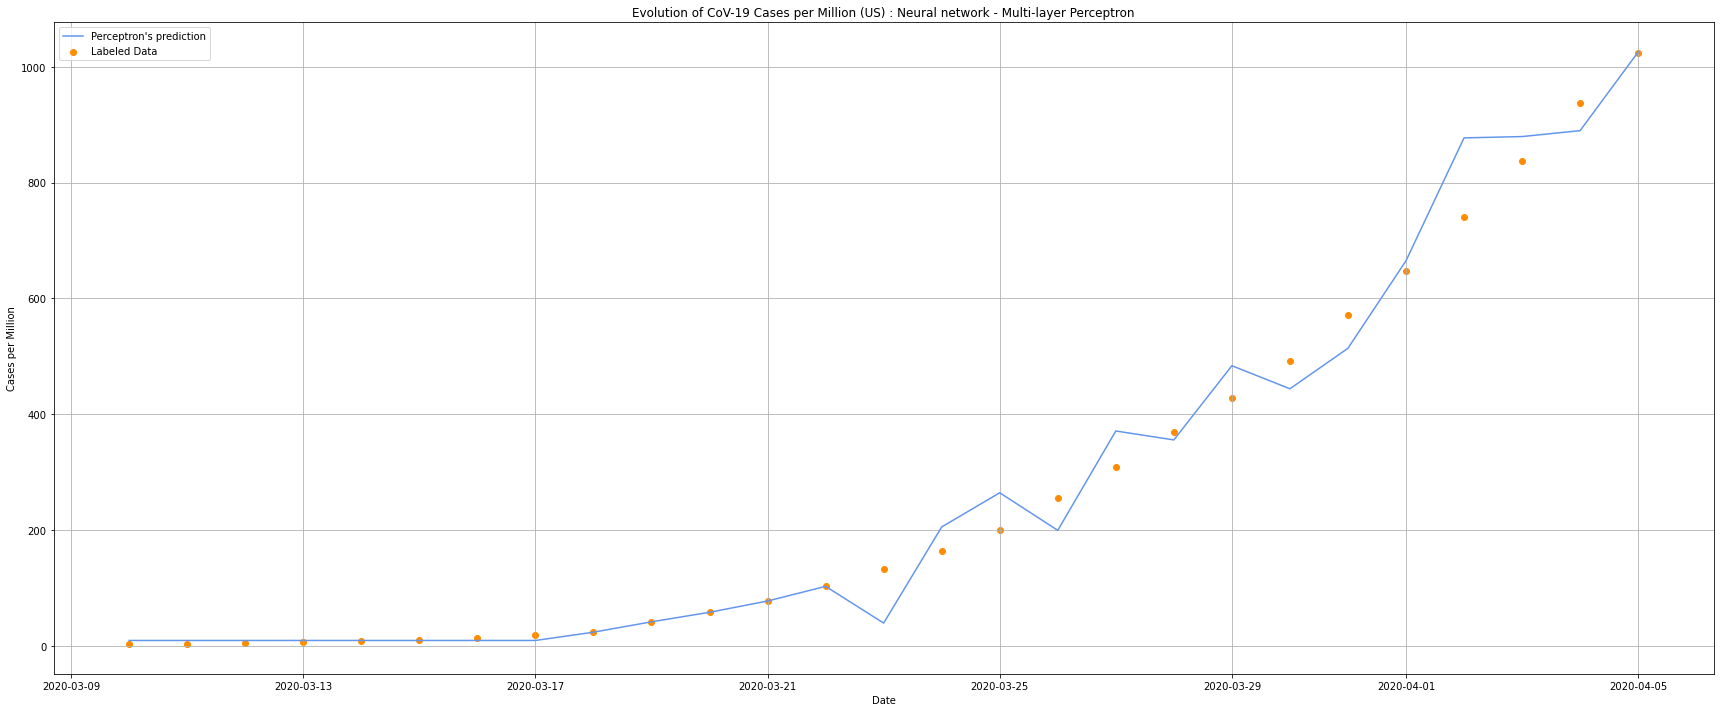

In [17]:
hidden_layers = 5
# Fitting/Training Neural Network (MLP) Model
model = MLPRegressor(hidden_layers, validation_fraction = 0, solver='lbfgs').fit(X_train, Y_train)
# coefs = model.coefs_

# Obtaining predictions from models
NN_predict = model.predict(X)

# Testing models
NN_score = model.score(X_test, Y_test)
# loss = np.square(Y - NN_predict).mean()
# print('Loss', loss)

print('Score', NN_score)

# Visual Comparison of the predictions obtained by the NN model
_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
labeled = ax.scatter(date_format[day_index:], Y, color='darkorange', label='data')
NN_plot, = ax.plot(date_format[day_index:], NN_predict, color='cornflowerblue')
ax.legend((NN_plot,labeled), ('Perceptron\'s prediction', 'Labeled Data'), loc='upper left', shadow=False)
ax.set(xlabel="Date", ylabel='Cases per Million', title = "Evolution of CoV-19 Cases per Million (%s) : Neural network - Multi-layer Perceptron" % (country))
plt.tight_layout()
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

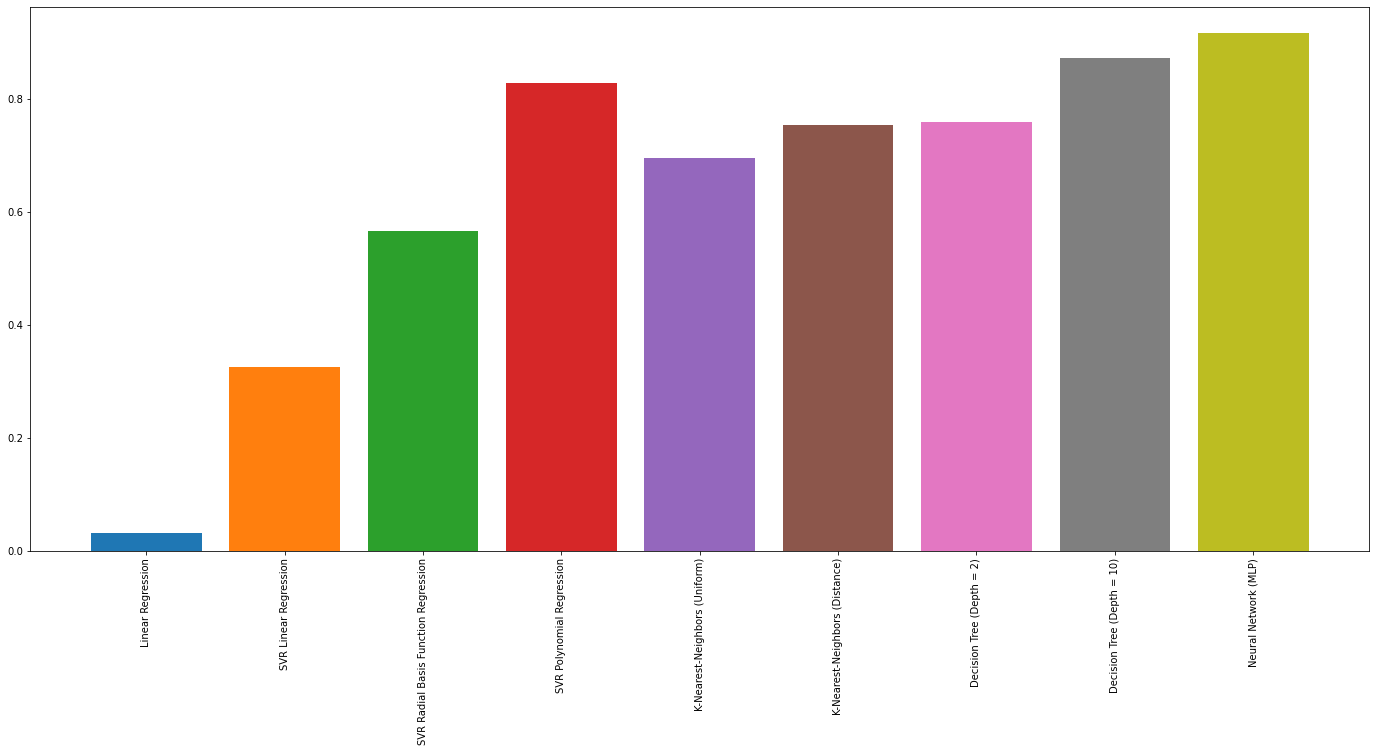

In [18]:
# Visual Comparison of the scores obtained by the different 
# models when predicting labeled data
_, ax = plt.subplots(figsize=(24, 10))
ax.bar('Linear Regression', linear_score, width=0.8, bottom=None, align='center', data=None)
ax.bar('SVR Linear Regression', svr_lin_score, width=0.8, bottom=None, align='center', data=None)
ax.bar('SVR Radial Basis Function Regression', svr_rbf_score, width=0.8, bottom=None, align='center', data=None)
ax.bar('SVR Polynomial Regression', svr_poly_score, width=0.8, bottom=None, align='center', data=None)

ax.bar('K-Nearest-Neighbors (Uniform)', knn_uniform_score, width=0.8, bottom=None, align='center', data=None)
ax.bar('K-Nearest-Neighbors (Distance)', knn_distance_score, width=0.8, bottom=None, align='center', data=None)

ax.bar('Decision Tree (Depth = 2)', dt_regressor_2_score, width=0.8, bottom=None, align='center', data=None)
ax.bar('Decision Tree (Depth = 10)', dt_regressor_10_score, width=0.8, bottom=None, align='center', data=None)

ax.bar('Neural Network (MLP)', NN_score, width=0.8, bottom=None, align='center', data=None)

plt.xticks(rotation=90)

In [19]:
### Principal Component Analysis

In [20]:
# Colunas 5 8 e 2
pca = PCA(0.95)
principalComponents = pca.fit_transform(X) 
print(pca.explained_variance_ratio_)
principalDf = pd.DataFrame(data = principalComponents) 
print(pca.components_)

[0.68247997 0.22296736 0.04696344]
[[ 0.39289409  0.37283452 -0.39404191  0.41568115  0.42553647  0.40800669
  -0.11841312  0.13037019]
 [ 0.13027736  0.07523198  0.0954432  -0.02519027 -0.02923957 -0.06659996
   0.69299011  0.69433292]
 [-0.1337239  -0.66305254 -0.54063077 -0.19280261 -0.00926701  0.43545896
   0.1354905   0.0704039 ]]


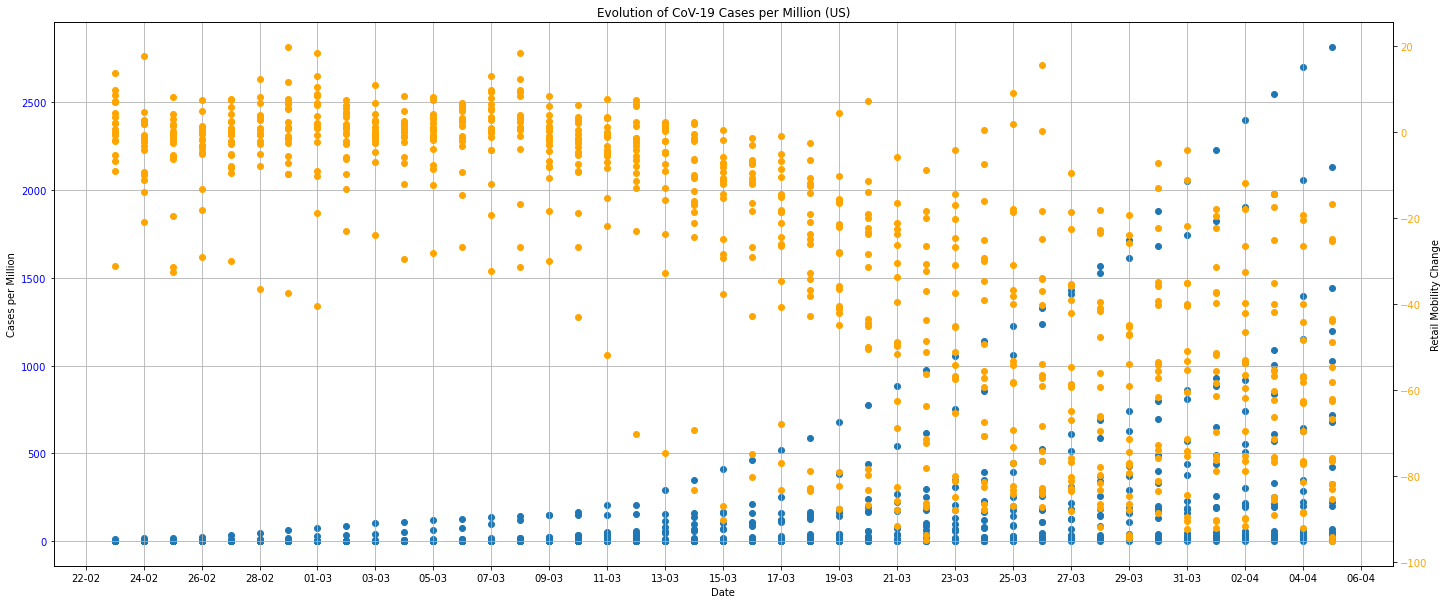

In [21]:
# Reads CVS file to Data Frame
data = pd.read_csv('Global_Mobility_Report.csv')
data = data.drop(columns = ['country','iso'])

# Calculates daily percentual changes in number of fatalities
data['fatalities_percent_change'] = pd.Series([])
for i in range(0,len(data['fatalities'])):
    if i != 0 and data['fatalities'][i-1] != 0:
        data['fatalities_percent_change'][i]= (data['fatalities'][i] - data['fatalities'][i-1]) * 100 /data['fatalities'][i-1]
    else:data['fatalities_percent_change'][i] = 0

# Calculates daily percentual changes in number of cases
data['cases_percent_change'] = pd.Series([])
for i in range(0,len(data['total_cases'])):
    if i != 0 and data['total_cases'][i-1] != 0:
        data['cases_percent_change'][i]= (data['total_cases'][i] - data['total_cases'][i-1]) * 100 /data['total_cases'][i-1]
    else:data['cases_percent_change'][i] = 0

# Calculates cases of covid per million inhabitants
data['cases_per_million'] = pd.Series([])
for i in range(0,len(data['total_cases'])):
    millions = data['population'][i]/1000000
    data['cases_per_million'][i]= data['total_cases'][i]/millions

# Drop unnecessary columns from data set
data = data.drop(columns = ['fatalities'])
data = data.drop(columns = ['total_cases'])
data = data.drop(columns = ['population'])

dates = data['date']
date_format = [pd.to_datetime(d) for d in dates]

_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
ax.scatter(date_format, data['cases_per_million'])
ax.set(xlabel="Date", ylabel='Cases per Million', title=("Evolution of CoV-19 Cases per Million (%s)" % (country)))
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.tick_params(axis='y', labelcolor= "blue")
ax2 = ax.twinx()  
ax2.set_ylabel('Retail Mobility Change')
ax2.scatter(date_format, data['retail_recreation'], color = "orange")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax2.tick_params(axis='y', labelcolor= "orange")
plt.show()

In [22]:
x = data.iloc[:,1:9]
print(x)
#assuming the last column is the one to be predicted
y = data.iloc[:,9:]
# Replaces NaN values present in the new columns by 0
x['fatalities_percent_change'] = x['fatalities_percent_change'].replace(np.NaN, 0)
x['cases_percent_change'] = x['cases_percent_change'].replace(np.NaN, 0)
y['cases_per_million'] = y['cases_per_million'].replace(np.NaN, 0)

# Fills the empty values taking mean values present in each column
x = x.replace("", np.NaN)
y = y.replace("", np.NaN)
imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')
x = imputer.fit_transform(x)
Y = imputer.fit_transform(y)


X = []
len = int(math.floor(len(x)/19)) 
for i in range(0,len):
    # Para cada data
    a = x[x[0] == x[0][i]]
    for j in range(0, len):
        # Para cada column
        sum = 0
        for k in range(0, len):
            # Percorrer a coluna
            sum += a[j][k]
        X[k][i] = sum /len

# Standardization using Gaussian Normal Distribution
x = preprocessing.scale(x)
print("---------------------------------------------------------\n",x)



grocery_pharmacy   parks  residential  retail_recreation  \
0               8.185  17.563        0.437             13.644   
1             -15.875  25.605        6.321             -9.973   
2             -17.135   1.325        6.895            -19.717   
3               2.304   5.399       -2.273              0.845   
4              -0.404  -5.267       -0.493             -0.584   
..                ...     ...          ...                ...   
812           -42.446 -37.600       34.916            -69.728   
813           -40.523 -38.226       36.550            -69.577   
814           -42.107 -43.271       38.379            -71.513   
815           -51.515 -57.252       26.499            -76.589   
816           -51.420 -53.273       22.351            -75.913   

     transit_stations  workplaces  fatalities_percent_change  \
0               5.334      -2.486                   0.000000   
1             -26.785     -53.687                   0.000000   
2             -28.485     -50.05

IndexError: boolean index did not match indexed array along dimension 0; dimension is 817 but corresponding boolean dimension is 8

In [23]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

hidden_layers = 5
model = MLPRegressor(hidden_layers, validation_fraction = 0, solver='lbfgs').fit(X_train, Y_train)
coefs = model.coefs_
NN_predict = model.predict(X)
NN_score = model.score(X_test, Y_test)
loss = np.square(Y - NN_predict).mean()
print('Loss', loss)
print('Score', NN_score)

# Plot the results
_, ax = plt.subplots(figsize=(24, 10))
ax.grid()
labeled = ax.scatter(date_format[day_index:], Y, color='darkorange', label='data')
NN_plot, = ax.plot(date_format[day_index:], NN_predict, color='cornflowerblue')
ax.legend((NN_plot,labeled), ('Perceptron\'s prediction', 'Labeled Data'), loc='upper left', shadow=False)
ax.set(xlabel="Date", ylabel='Cases per Million', title = "Evolution of CoV-19 Cases per Million (%s) : Neural network - Multi-layer Perceptron" % (country))
plt.tight_layout()
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [0, 817]

In [24]:
# # Instantiate Linear Regression
# linear_regr = linear_model.LinearRegression()
# linear_regr.fit(X_train, Y_train)
# print("Linear Regression Model Score: %s" % (linear_regr.score(X_test, Y_test)))
# y_pred = linear_regr.predict(X_test)

# plt.figure(figsize=(24, 10))
# plt.grid()
# plt.scatter(days, y)
# plt.plot(X_test['day'], y_pred, color='green', linewidth=2)
# plt.ylabel('cases_percent_change')
# plt.yscale('linear')
# plt.savefig('retail_and_recreation_percent_change_from_baseline_prediction.png')
# plt.show()

In [25]:
# svr_poly = SVR(kernel='poly', C=1e3, degree=2)
# y_poly = svr_poly.fit(days_train, retail_train)
# print("POLY Regression Model Score: %s" % (y_poly.score(days_test, retail_test)))
# y_pred_poly = y_poly.predict(days)
# retail_train

In [26]:
# knn = neighbors.KNeighborsRegressor(3, weights='distance')
# y_ = knn.fit(days_train, retail_train).predict(retail)

In [27]:
# plt.figure(figsize=(24, 10))
# plt.grid()
# # plot linear regression prediction

# plt.scatter(days, fatal)
# plt.scatter(days, retail)
# # plt.plot(days, y_fatal_pred, color='red', linewidth=2)
# plt.plot(days, y_, color='green', linewidth=2)
# plt.show()